In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from scipy.stats import norm
from scipy.stats import multivariate_normal

SAMPLES = 700
NOISE = 0.1

# Generate the data
X, _ = make_moons(n_samples=SAMPLES, noise=NOISE)


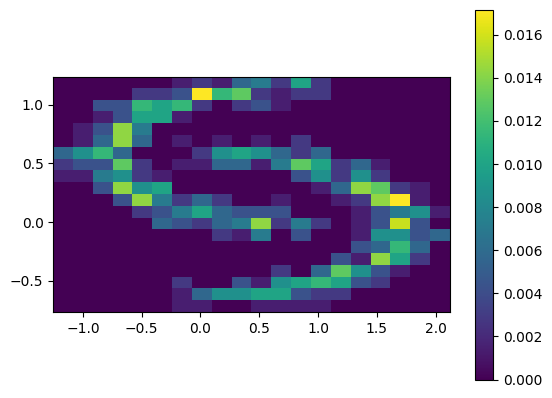

In [25]:
def histogram(BINS, visualize = False):
    # Create a 2D histogram
    hist, x_edges, y_edges = np.histogram2d(X[:, 0], X[:, 1], bins=BINS)
    hist = hist / hist.sum()

    if visualize:# Visualize the histogram
        plt.imshow(hist, interpolation='nearest', origin='lower', extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
        plt.colorbar()
        plt.show()
    return hist, x_edges, y_edges

hist, x_edges, y_edges = histogram(20, True)

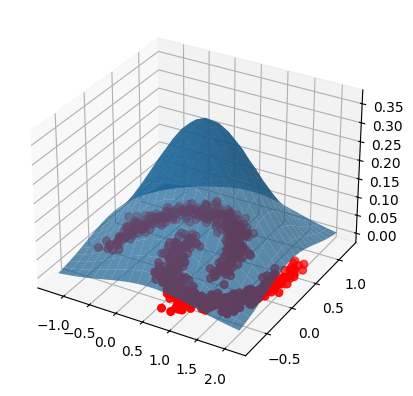

In [26]:
# using the hist data from above
x, y = np.meshgrid(x_edges, y_edges)

# Fit a Gaussian to the histogram data
x_mean = np.mean(X[:, 0])
x_std = np.std(X[:, 0])
y_mean = np.mean(X[:, 1])
y_std = np.std(X[:, 1])
pdf = norm.pdf(x, loc=x_mean, scale=x_std) * norm.pdf(y, loc=y_mean, scale=y_std)

# Visualize the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], np.zeros(len(X)), c='r', marker='o', s=30, label="Data Points")
ax.plot_surface(x, y, pdf, alpha=0.7)

plt.show()


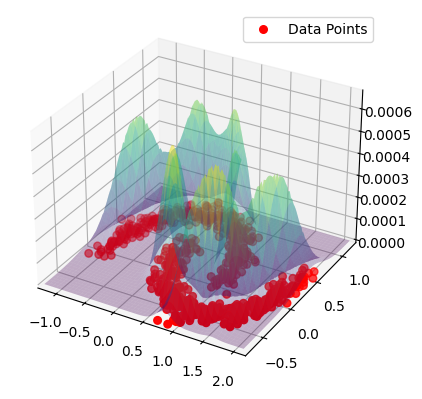

In [5]:
def GMM(components, visualize = False):
    # Initialize parameters
    np.random.seed(0)
    mu = np.random.rand(components, 2)  # Random initial means
    cov = np.array([np.eye(2)] * components)  # Initialize with identity covariance matrices
    weights = np.ones(components) / components  # Equal component weights

    # Define the number of iterations
    n_iterations = 100

    # Create a grid for visualization
    x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))


    for _ in range(n_iterations):
        # Expectation step: Calculate responsibilities
        responsibilities = np.zeros((len(X), components))
        for i in range(components):
            responsibilities[:, i] = weights[i] * multivariate_normal.pdf(X, mean=mu[i], cov=cov[i])
        responsibilities /= responsibilities.sum(axis=1)[:, np.newaxis]

        # Maximization step: Update parameters
        N_k = responsibilities.sum(axis=0)
        weights = N_k / len(X)
        for i in range(components):
            mu[i] = (1 / N_k[i]) * np.sum(X * responsibilities[:, i][:, np.newaxis], axis=0)
            cov[i] = (1 / N_k[i]) * np.dot((responsibilities[:, i][:, np.newaxis] * (X - mu[i])).T, (X - mu[i])) + 1e-6 * np.eye(2)

        # Calculate the PDF for the entire grid
        pdf = np.zeros(x.shape)
        for i in range(components):
            pdf += weights[i] * multivariate_normal.pdf(np.dstack((x, y)), mean=mu[i], cov=cov[i])
    # normalize
    pdf /= pdf.sum()

    if visualize:# Visualize the PDF surface
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(x, y, pdf, cmap='viridis', alpha=0.3)

        # Set the extent (limits) of the plot for X, Y, and Z
        ax.set_xlim(X[:, 0].min(), X[:, 0].max())
        ax.set_ylim(X[:, 1].min(), X[:, 1].max())
        ax.set_zlim(0, pdf.max())  # Adjust the Z-axis limit based on your data and PDF

        # Visualize the data points
        ax.scatter(X[:, 0], X[:, 1], np.zeros(len(X)), c='r', marker='o', s=30, label="Data Points")

        plt.legend()
        plt.show()
    return pdf

gmm = GMM(8, True)

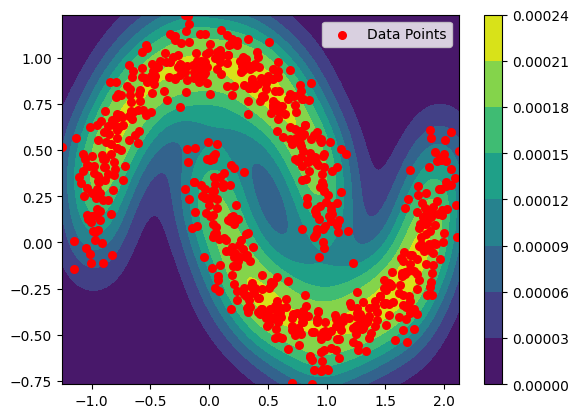

In [19]:
def KDE(BANDWIDTH, visualize = False):# Define the kernel function (Squared Exponential Kernel)
    def kernel(point, datapoint):
        return np.exp(-((point - datapoint) ** 2).sum() / 2 / BANDWIDTH**2)

    # Create a grid for visualization
    x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100), np.linspace(X[:, 1].min(), X[:, 1].max(), 100))

    # Initialize the KDE estimate
    pdf = np.zeros(x.shape)

    # Compute the KDE estimate for each point on the grid
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            point = np.array([x[i, j], y[i, j]])
            for data_point in X:
                pdf[i, j] += kernel(point, data_point)

    # Normalize the PDF to represent a probability density
    pdf /= pdf.sum()

    if visualize:# Visualize the KDE estimate
        plt.contourf(x, y, pdf, cmap='viridis')
        plt.colorbar()
        plt.scatter(X[:, 0], X[:, 1], c='r', marker='o', s=30, label="Data Points")
        plt.legend()
        plt.show()
    
    return pdf

kde = KDE(0.2, True)

In [20]:
def kernelexpectation(data1, data2, kernel): # returns E[k(data1, data2)]
    n = len(data1)
    if n != len(data2):
        raise ValueError("the two data arrays entered should have the same length")
    
    expectation = 0
    for i in range(n):
        for j in range(n):
            expectation += kernel(data1[i], data2[j])
    return expectation / n / (n-1)

def MMD(data, refference, kernel):
    return kernelexpectation(data, data, kernel) + kernelexpectation(refference, refference, kernel) - 2*kernelexpectation(data, refference, kernel)

In [21]:
# define kernels
def squared_exponential(x, y, sigma = 0.2):
    return np.exp( -( (x-y)**2 ).sum() / (2 * sigma**2) )
def multi_quadratic(x, y, sigma = 0.2):
    return 1 / ( 1 + ( (x-y)**2 ).sum() / (2 * sigma**2) )

10
20
30
40
[0.7484515108618504, 0.7463786549716739, 0.7471006368873174, 0.7475625617672481]


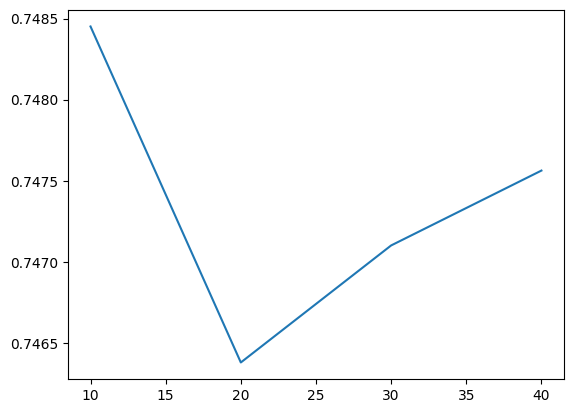

In [24]:
def visualiseMMD(estimator, kernel, hyperparameterrage):
    
    mmd = []
    for hyper in hyperparameterrage:
        print(hyper)
        # Number of samples to generate
        n = len(X[:, 0])
        # some values of X for later
        x0, y0 = X[0, 0], X[0, 1]
        xspan, yspan = X[-1, 0] - X[0, 0], X[-1, 1] - X[0, 1]

        # Generate random samples from the CDF
        samples = []
        
        # sample drawing from the estimator
        pdf = estimator(hyper)
        pdf_length = len(pdf)
        # Create a flat copy of the array
        flat = pdf.flatten()
        for i in range(n):
            # Then, sample an index from the 1D array with the
            # probability distribution from the original array
            sample_index = np.random.choice(a=flat.size, p=flat)
            
            # Take this index and adjust it so it matches the original array
            adjusted_index = np.unravel_index(sample_index, pdf.shape)
            # calculate x,y from index
            sample = [x0 + adjusted_index[0] * xspan/pdf_length , y0 + adjusted_index[1] * yspan/pdf_length ]
            samples.append(sample)
            
        mmd.append(MMD(X, np.array(samples), kernel))
    
    print(mmd)
    plt.plot(hyperparameterrage, mmd)

visualiseMMD(histogram, multi_quadratic, [10,20,30,40])